In [270]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import itertools 
%matplotlib inline 

from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet 

from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor, VotingRegressor, ExtraTreesRegressor 
# Support vector regressor
from sklearn.svm import SVR 
from xgboost.sklearn import XGBRegressor

from sklearn import metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.utils import resample

from scipy import stats
from scipy.stats import zscore

In [230]:
from pyforest import*
#lazy_imports()

In [231]:
df = pd.read_csv('./data/compresive_strength_concrete.csv')

<IPython.core.display.Javascript object>

In [232]:
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [233]:
df.dtypes

Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     float64
Fine Aggregate (component 7)(kg in a m^3 mixture)        float64
Age (day)                                                  int64
Concrete compressive strength(MPa, megapascals)          float64
dtype: object

In [234]:
#'Concrete compressive strength(MPa, megapascals) ', there is a unnecessary space in this column name
# This has been considered during renaming it
df = df.rename({'Cement (component 1)(kg in a m^3 mixture)':'cement', 
                   'Blast Furnace Slag (component 2)(kg in a m^3 mixture)':'slag',
                   'Fly Ash (component 3)(kg in a m^3 mixture)':'ash',
                   'Water  (component 4)(kg in a m^3 mixture)':'water',
                   'Superplasticizer (component 5)(kg in a m^3 mixture)':'plasticizer',
                   'Coarse Aggregate  (component 6)(kg in a m^3 mixture)':'coarse',
                   'Fine Aggregate (component 7)(kg in a m^3 mixture)':'fineAggregate',
                   'Age (day)':'age', 
                   'Concrete compressive strength(MPa, megapascals) ':'strength'},
                   axis=1);

In [235]:
df

,cement,slag,ash,water,plasticizer,coarse,fineAggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [236]:
df.shape

(1030, 9)

In [237]:
df.isna().sum()

cement           0
slag             0
ash              0
water            0
plasticizer      0
coarse           0
fineAggregate    0
age              0
strength         0
dtype: int64

In [238]:
df.isnull().sum()

cement           0
slag             0
ash              0
water            0
plasticizer      0
coarse           0
fineAggregate    0
age              0
strength         0
dtype: int64

In [239]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
plasticizer,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarse,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineAggregate,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6



## Exploratory Analysis

In [240]:
q1 = df['cement'].quantile(q=0.25)
q2 = df['cement'].quantile(q=0.5)
q3 = df['cement'].quantile(q=0.75)
print('First quantile is(Q1): {}'.format(q1))
print('Second quantile is(Q2): {}'.format(q2))
print('Third quantile is(Q3): {}'.format(q3))

First quantile is(Q1): 192.375
Second quantile is(Q2): 272.9
Third quantile is(Q3): 350.0


In [241]:
stats.iqr(df['cement']) # Interquartile range(Q3-Q1)

157.625

In [242]:
u_outliers_limit = q3 + 1.5 * stats.iqr(df['cement'])
l_outliers_limit = q1 - 1.5 * stats.iqr(df['cement'])

#df[df['cement'] > u_outliers_limit]['cement'].count()  #counting number of outliers
#df[df['cement'] < l_outliers_limit]['cement'].count()

print((df[df['cement'] > u_outliers_limit]['cement'].count() * 100)/df.shape[0], '%') #printed percentage of outliers
print((df[df['cement'] < l_outliers_limit]['cement'].count() * 100)/df.shape[0], '%')

0.0 %
0.0 %


<IPython.core.display.Javascript object>

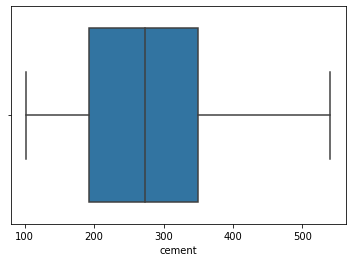

In [243]:
sns.boxplot(x='cement', data=df, orient='h')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

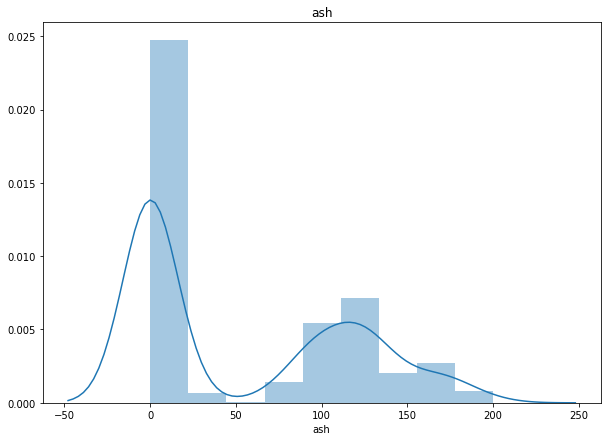

In [244]:
plt.figure(figsize=(10,7))
plt.title('ash')
sns.distplot(df['ash'])

<IPython.core.display.Javascript object>

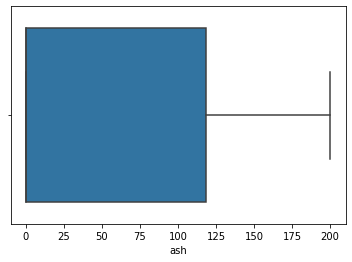

In [245]:
sns.boxplot(df['ash'], orient='h') 

In [246]:
df.dtypes

cement           float64
slag             float64
ash              float64
water            float64
plasticizer      float64
coarse           float64
fineAggregate    float64
age                int64
strength         float64
dtype: object

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

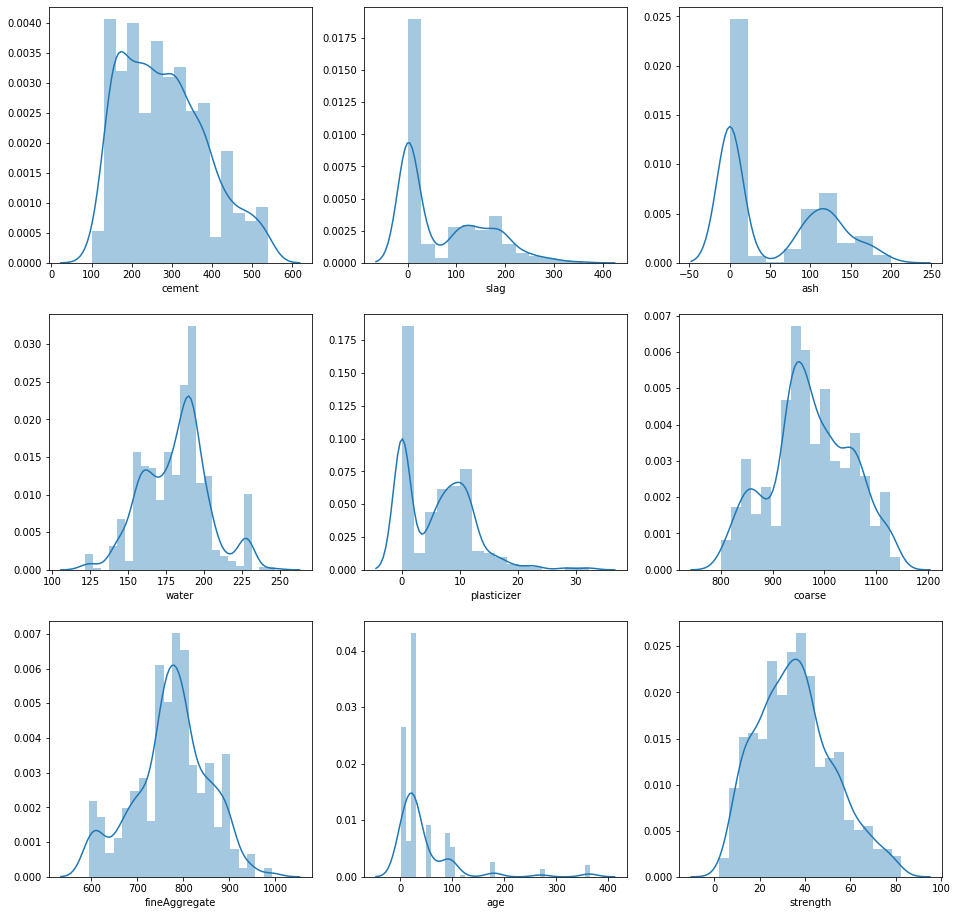

In [247]:
fig1, ax1 = plt.subplots(3, 3, figsize=(16,16))
sns.distplot(df['cement'], ax=ax1[0][0])
sns.distplot(df['slag'], ax=ax1[0][1])
sns.distplot(df['ash'], ax=ax1[0][2])
sns.distplot(df['water'], ax=ax1[1][0])
sns.distplot(df['plasticizer'], ax=ax1[1][1])
sns.distplot(df['coarse'], ax=ax1[1][2])
sns.distplot(df['fineAggregate'], ax=ax1[2][0])
sns.distplot(df['age'], ax=ax1[2][1])
sns.distplot(df['strength'], ax=ax1[2][2])

<IPython.core.display.Javascript object>

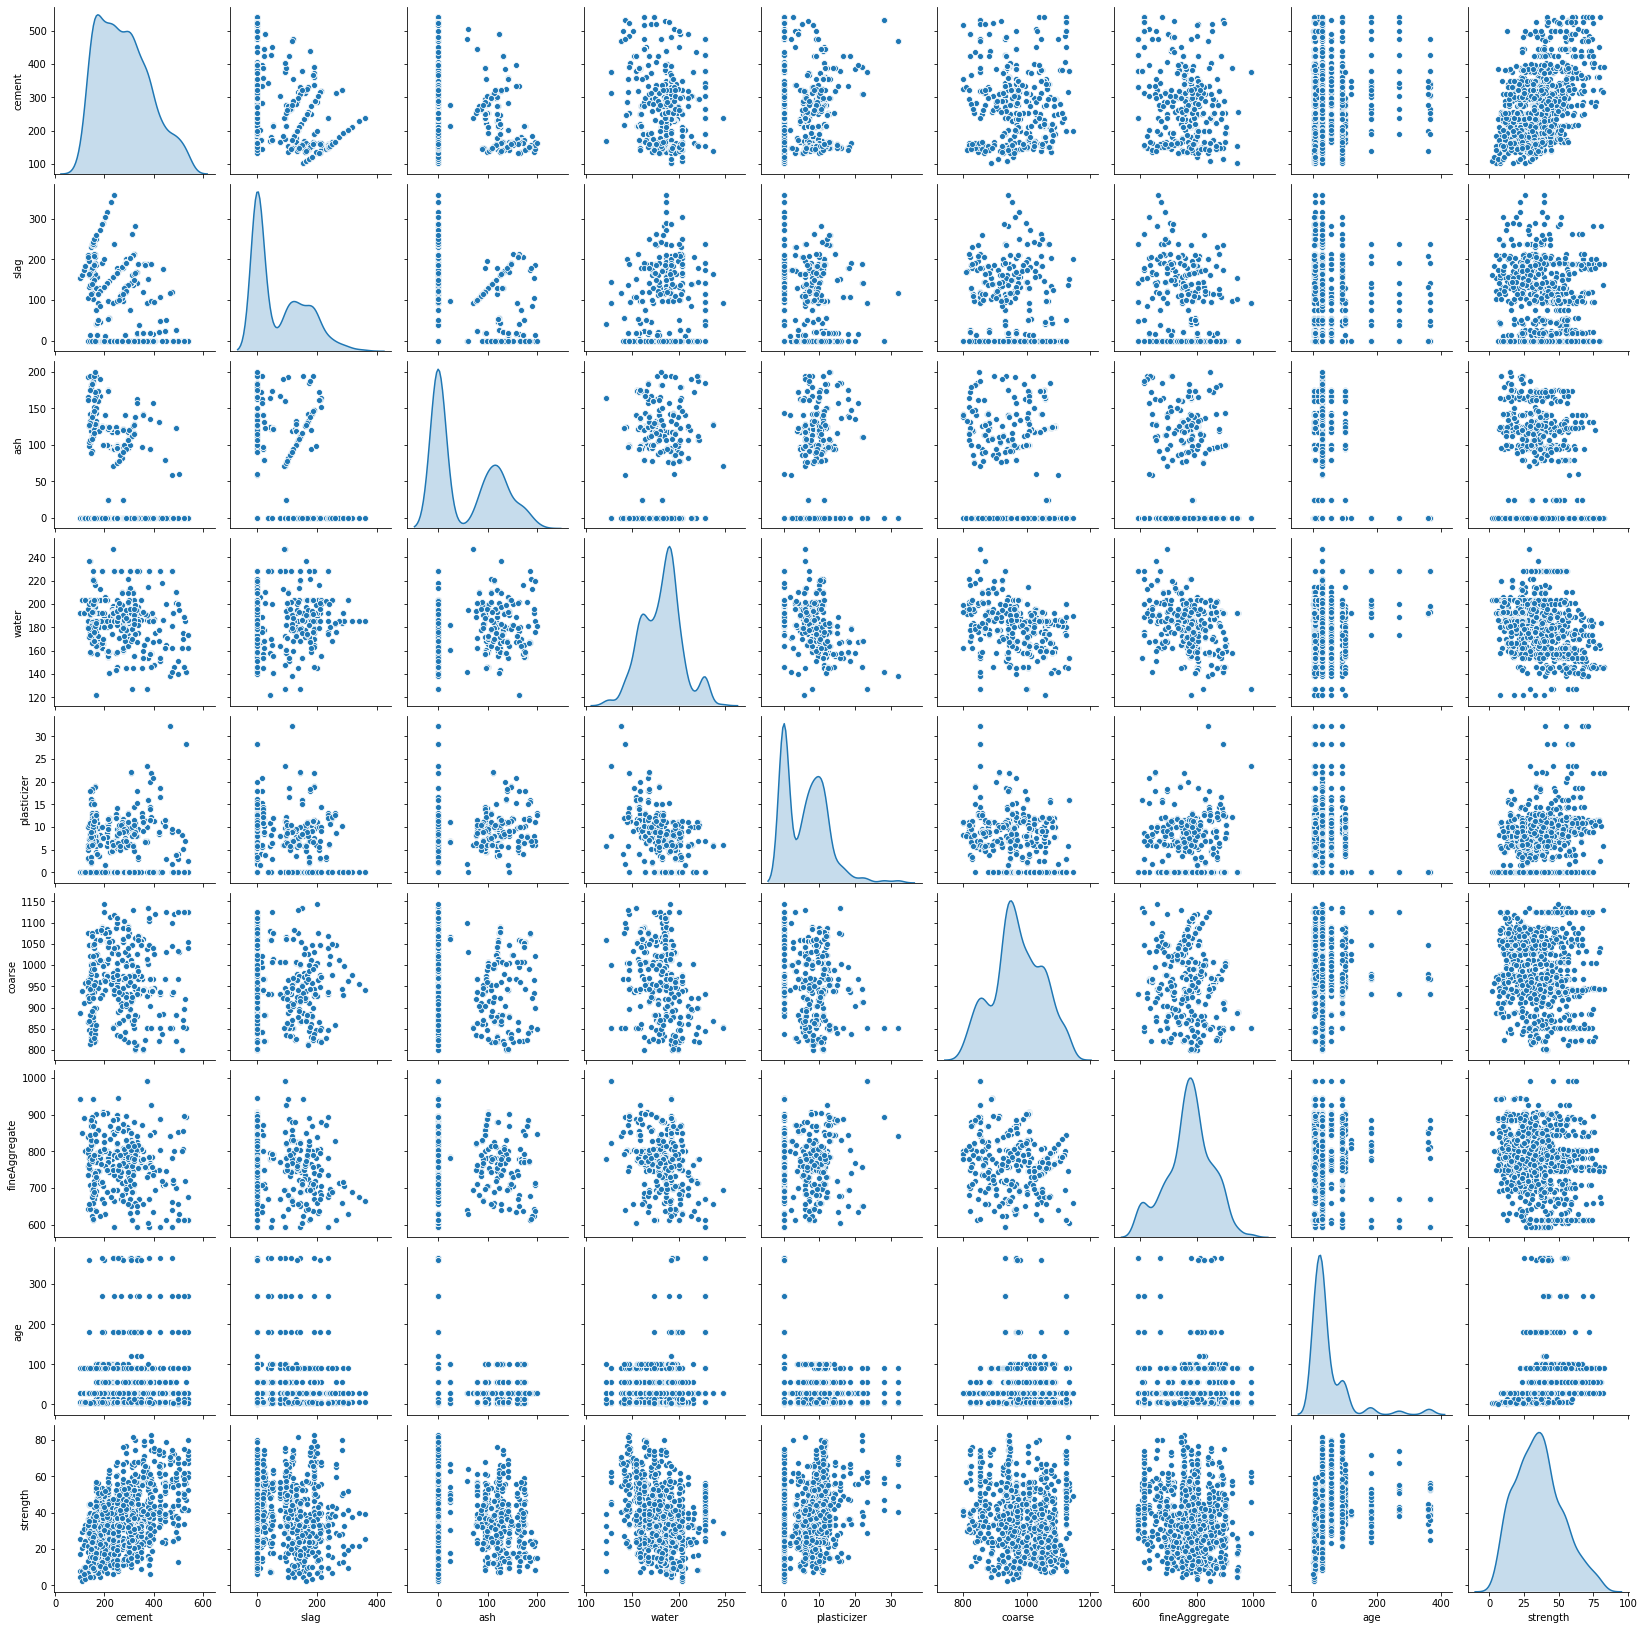

In [248]:
sns.pairplot(df, diag_kind='kde');

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

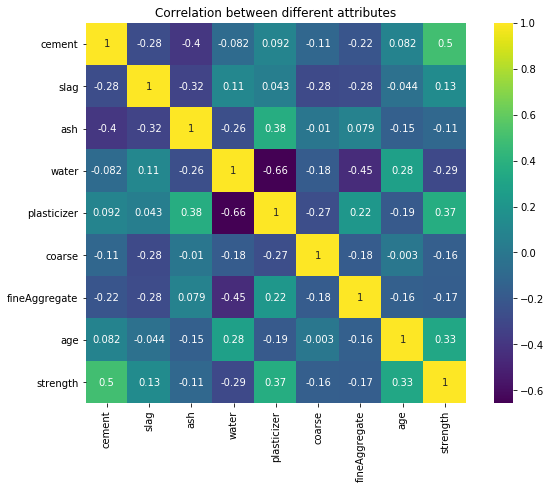

In [249]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), vmax=1, square=True, annot=True, cmap='viridis')
plt.title('Correlation between different attributes')
plt.show()

<IPython.core.display.Javascript object>

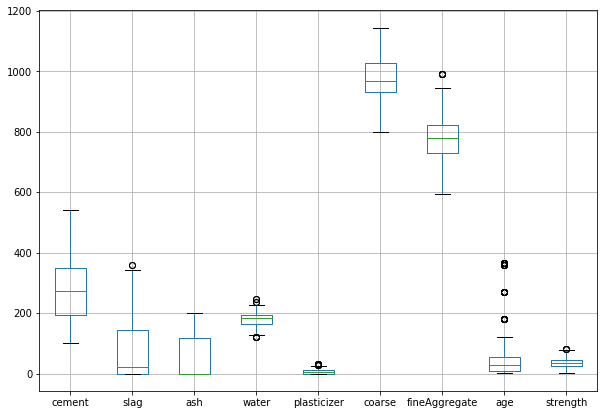

In [250]:
plt.figure(figsize=(10,7))
df.boxplot()

In [251]:
# Calculate outliers for each column
# Target column is excluded by "len(df.columns) - 1"
# outliers = ((x - x.mean)/x.std).abs() > 3     # value outside 3 standard deviation 

for col in df.columns[:-1]:
    outliers_index = ((df[col] - df[col].mean())/df[col].std()).abs() > 3;
    
    outliers_no = df.loc[outliers_index, col].count() 
    
    print('Outliers in {}: {}'.format(col, outliers_no))


Outliers in cement: 0
Outliers in slag: 4
Outliers in ash: 0
Outliers in water: 2
Outliers in plasticizer: 10
Outliers in coarse: 0
Outliers in fineAggregate: 0
Outliers in age: 33


In [252]:
# Replacing outliers from every column

for col in df.columns[:-1]:
    q1 = df[col].quantile(q=0.25)
    q3 = df[col].quantile(q=0.75)
    
    iqr = q3 - q1
    
    lower_limit = q1 - 1.5 * iqr;
    upper_limit = q3 + 1.5 * iqr;
    
    df.loc[(df[col] < lower_limit) | (df[col] > upper_limit), col] = df[col].median()  

<IPython.core.display.Javascript object>

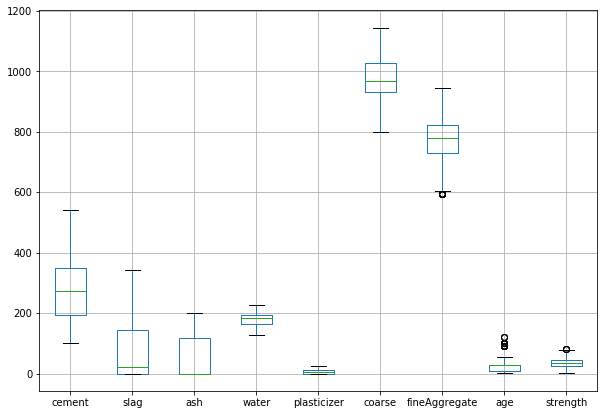

In [253]:
plt.figure(figsize=(10,7))
df.boxplot()

In [254]:
X = df.drop('strength', axis=1)
y = df['strength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

<IPython.core.display.Javascript object>

In [255]:
X_train = X_train.apply(zscore)
X_test = X_test.apply(zscore)
X = X.apply(zscore)

'''
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X = scaler.fit_transform(X)
'''

'\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.fit_transform(X_test)\nX = scaler.fit_transform(X)\n'

In [256]:
# Test k value for KNeighborsRegressor
'''
score_diff_k = []
r2_scores = []
for neighbors in range(1, 20):
    model =  KNeighborsRegressor(n_neighbors=neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_scr = metrics.r2_score(y_test, y_pred)
    r2_scores.append(r2_scr)

plt.figure(figsize=(10,7))
plt.plot(range(1,20), r2_scores, marker='*')
plt.xlabel('No of neighbors')
plt.ylabel('Error')
'''

"\nscore_diff_k = []\nr2_scores = []\nfor neighbors in range(1, 20):\n    model =  KNeighborsRegressor(n_neighbors=neighbors)\n    model.fit(X_train, y_train)\n    y_pred = model.predict(X_test)\n    r2_scr = metrics.r2_score(y_test, y_pred)\n    r2_scores.append(r2_scr)\n\nplt.figure(figsize=(10,7))\nplt.plot(range(1,20), r2_scores, marker='*')\nplt.xlabel('No of neighbors')\nplt.ylabel('Error')\n"

In [257]:
# plt.bar(df.columns ,model.feature_importances_)
df.columns

Index(['cement', 'slag', 'ash', 'water', 'plasticizer', 'coarse',
       'fineAggregate', 'age', 'strength'],
      dtype='object')

In [271]:
models = []
models.append(('RanFR', RandomForestRegressor()))
models.append(('LinR', LinearRegression()))
models.append(('GrdBR', GradientBoostingRegressor()))
models.append(('AdaBR', AdaBoostRegressor()))
models.append(('KNeiR', KNeighborsRegressor(n_neighbors=4)))
models.append(('BagR', BaggingRegressor()))
models.append(('SVR', SVR(kernel='linear')))
models.append(('XGBR', XGBRegressor()))
models.append(('DecTR', DecisionTreeRegressor()))
models.append(('XGDR', XGBRegressor()))
models.append(('ExtraTR', ExtraTreesRegressor()))
models.append(('ElasticN', ElasticNet()))

In [272]:
train_scores = []
test_scores = []
r2_scores = []
mse_scores = []
cv_scores = []
model_names = []

for name, model in models:
    model.fit(X_train, y_train)
    
    train_scr = model.score(X_train, y_train)
    train_scores.append(train_scr)
    
    y_pred = model.predict(X_test)
    r2_scr = metrics.r2_score(y_test, y_pred)
    r2_scores.append(r2_scr)
    
    mse_scr = metrics.mean_squared_error(y_test, y_pred)
    mse_scores.append(mse_scr)
    
    test_scr = model.score(X_test, y_test) 
    test_scores.append(test_scr)
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_scr = cross_val_score(model, X, y, cv=kfold)    # It will generate 10 score
    cv_scr_mean = np.mean(abs(cv_scr))
    cv_scores.append(cv_scr_mean)
            
    model_names.append(name)
    

In [274]:
pd.DataFrame({'algorithm':model_names, 'train_scr':train_scores, 'test_scr':test_scores,
             'r2_scr':r2_scores, 'mse_scr':mse_scores, 'kfold':cv_scores})

,algorithm,train_scr,test_scr,r2_scr,mse_scr,kfold
0,RanFR,0.976673,0.830409,0.830409,46.184514,0.905937
1,LinR,0.689698,0.645955,0.645955,96.416664,0.673013
2,GrdBR,0.933411,0.815700,0.815700,50.190392,0.884223
3,AdaBR,0.800808,0.742294,0.742294,70.180769,0.768779
4,KNeiR,0.893782,0.798035,0.798035,55.001018,0.833165
5,BagR,0.970778,0.822436,0.822436,48.355971,0.897024
6,SVR,0.688533,0.645229,0.645229,96.614614,0.671773
7,XGBR,0.987393,0.819905,0.819905,49.045173,0.921388
8,DecTR,0.988973,0.703484,0.703484,80.749848,0.855374
9,XGDR,0.987393,0.819905,0.819905,49.045173,0.921388


In [261]:
# Understand the different feature's importance 
'''
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

imp = pd.DataFrame(model.feature_importances_, columns=['importance'], index=X_train.columns)

plt.figure(figsize=(7,4))
plt.barh(imp.index, imp['importance'])
'''

"\nmodel = DecisionTreeRegressor()\nmodel.fit(X_train, y_train)\n\nimp = pd.DataFrame(model.feature_importances_, columns=['importance'], index=X_train.columns)\n\nplt.figure(figsize=(7,4))\nplt.barh(imp.index, imp['importance'])\n"

In [262]:
# Selecting important features
df_imp = df.copy()

X = df_imp.drop(['ash', 'plasticizer', 'fineAggregate', 'coarse', 'strength'], axis=1)
y = df_imp['strength']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

X_train = X_train.apply(zscore)
X_test = X_test.apply(zscore)
X = X.apply(zscore)

<IPython.core.display.Javascript object>

In [263]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

train_scr = model.score(X_train, y_train)

r2_scr = metrics.r2_score(y_test, y_pred)

mse_scr = metrics.mean_squared_error(y_test, y_pred)

test_scr = model.score(X_test, y_test) 


In [264]:
test_scr

0.7042361631960783